In [28]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator

from scipy.integrate import odeint

We solve the couple of differential equations

$$\frac{d \bar{R}}{dt} = \frac{1}{\tau_v} \left[\delta \bar{C} - \frac{\epsilon}{\bar{R}} \right]$$
$$\frac{d \bar{C}}{dt} = \frac{1}{\tau_s} \left[\bar{j}_s - \delta \bar{C} \right]$$

where $\delta \bar{C} = \bar{C} - 1$.


The stationary state 

In [2]:
def dRdt(t, R, C, eps, tauv) :
    return (C - eps/R)/tauv

def dCdt(t, R, C, js, taus) :
    return R*(js - C)/taus

def f(Y, t, eps, js, taus, tauv) :
    R, C = Y
    #eps, js, taus, tauv = args
    dR = dRdt(t, R, C, eps, tauv)
    dC = dCdt(t, R, C, js, taus)
    return [dR, dC]


/usr/local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


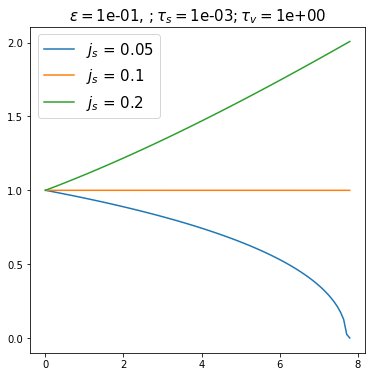

In [32]:
R0, C0 = 1., 0.

eps = 1e-1
taus, tauv = 1e-3, 1.

t = np.linspace(0., 7.8, 101)

js_list = [0.05, .1, .2]


fig, ax = plt.subplots(1,1, figsize=(6,6))

for js in js_list:
    y0 = [R0, C0]
    sol = odeint(f, y0, t, args=(eps, js, taus, tauv))
    ax.plot(t, sol[:, 0], label = r'$j_s$ = '+str(js))
    
ax.legend(fontsize=15)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))

plt.title(r'$\epsilon=$'+"{:2.0e}".format(eps)+r', $ ; \tau_s = $'+"{:2.0e}".format(taus)+ r'$ ; \tau_v =$'+"{:2.0e}".format(tauv), fontsize=15)
plt.savefig('/Users/mathieuleverge/Documents/pumping_threshold.eps', format='eps')

plt.show()
